In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler

In [3]:
df_samsung = fdr.DataReader('005930', start='2021-01-01')
df_samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170


In [5]:
df_samsung.reset_index(inplace=True)

In [6]:
df_samsung

,Date,Open,High,Low,Close,Volume,Change
0,2021-01-04,81000,84400,80200,83000,38655276,0.024691
1,2021-01-05,81600,83900,81600,83900,35335669,0.010843
2,2021-01-06,83300,84500,82100,82200,42089013,-0.020262
3,2021-01-07,82800,84200,82700,82900,32644642,0.008516
4,2021-01-08,83300,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...,...,...
371,2022-07-05,57600,58200,57200,57200,14216539,0.001751
372,2022-07-06,57300,57300,56400,56400,16820461,-0.013986
373,2022-07-07,56400,58700,56300,58200,21322833,0.031915
374,2022-07-08,58600,59300,58200,58700,15339271,0.008591


In [ ]:
dates = df_samsung['Date']
cols = list(df_samsung)[1:-2]
df_for_training = df_samsung[cols].astype(float)
df_for_training

In [ ]:
df_for_training.plot.line()

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_scaled = scaler.transform(df_for_training)
df_scaled

In [ ]:
# df_scaled[0:1, 0:4]
df_scaled[1:15, 0]

In [ ]:
train_x = []
train_y = []

n_past = 1
n_future = 14

for i in range(n_past, len(df_scaled)-n_future+1):
    train_x.append(df_scaled[i-n_past : i, 0 : df_for_training.shape[1]])
    train_y.append(df_scaled[i+n_future-1 : i+n_future, 0])

train_x, train_y = np.array(train_x), np.array(train_y)

print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
history = model.fit(train_x, train_y, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='Traing Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
n_future = 30
forecast_period_dates = pd.date_range(list(dates)[-1], periods=n_future, freq='1d').tolist()
forecast = model.predict(train_x[-n_future:])

In [ ]:
forecast_period_dates

In [ ]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

In [ ]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
forecast_dates

In [ ]:
df_forecast = pd.DataFrame({"Date":np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [ ]:
df_forecast

In [ ]:
original = df_samsung[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-1-1']

In [ ]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

In [7]:
df_samsung['Date'] = pd.to_datetime(df_samsung['Date'])

In [ ]:
from sklearn import preprocessing

def call_dataset(ticker = '005930', stt = '2015-01-01', end = '2021-03-30', history_points = 50):
    data = fdr.DataReader(ticker, stt, end)
    data = data.iloc[:,0:-1]
    print('data: ', data.shape)
    data = data.values # 값만 갖고온다
    data_normalizer = preprocessing.MinMaxScaler() # 데이터를 0~1 범위로 점철되게 하는 함수 call
    data_normalized = data_normalizer.fit_transform(data) # 데이터를 0~1 범위로 점철되게 함수 수행
    print('data_normalized: ', data_normalized.shape)
     # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalized = np.array([data_normalized[i:i + history_points].copy() for i in range(len(data_normalized) - history_points)]) # ohlcv를 가지고 오되, 관찰일수 만큼 누적해서 쌓는다. (열방향으로)
    print('ohlcv_histories_normalized: ', ohlcv_histories_normalized.shape)

    next_day_open_values_normalized = np.array([data_normalized[:, 0][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_open_values_normalized = np.expand_dims(next_day_open_values_normalized, -1) # 1XN 벡터 -> NX1 벡터로

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1) # 1XN 벡터 -> NX1 벡터로

    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(next_day_open_values)

    # 인풋 X : 그 이전의 OHLCV (from T = -50 to T = -1)
    # 아웃풋 y : 예측하고자 하는 주가 T = 0

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalized:
        # note since we are using his[3] we are taking the SMA of the closing price
        # print('his: ', his)
        # print('his[:, 3]: ', his[:, 3])
        sma = np.mean(his[:, 3]) # 각 데이터포인트별 Close Price 평균
        macd = calc_ema(his, 12) - calc_ema(his, 26) # 12일 EMA - 26일 EMA
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalized.shape[0] == next_day_open_values_normalized.shape[0] == technical_indicators_normalized.shape[0]

    print('ohlcv_histories_normalized.shape[0]: ', ohlcv_histories_normalized.shape[0])

    return ohlcv_histories_normalized, technical_indicators_normalized, next_day_open_values_normalized, next_day_open_values, y_normalizer

In [ ]:
history_points = 50
ticker = '000660' # sk hynix

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
np.random.seed(4)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(44)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

In [ ]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

In [ ]:
y_test_predicted

In [ ]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('SK Hynix Using LSTM by TGG')
plt.show()

In [ ]:
def call_data(ticker:str, start_date:str, end_date:str, history_points:int):
    data = fdr.DataReader(ticker, start_date, end_date)
    data = data.iloc[:, 0:-1]
    print(f'data shape: {data.shape}')
    data = data.values

    data_normalizer = preprocessing.MinMaxScaler()
    data_normalized = data_normalizer.fit_transform(data)
    print(f'normalized data shape: {data_normalized.shape}')

    data_histories_normalized = np.array([data_normalized[i: i+history_points].copy() for i in range(len(data_normalized) - history_points)])
    print(f'data_histories_normalized shape: {data_histories_normalized.shape}')

    next_day_open_values_normalized = np.array([data_normalized[:, 0][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_open_values_normalized = np.expand_dims(next_day_open_values_normalized, -1) # 1 X n vector -> n X 1 vercor
    
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)
    print(f'next day open values shape: {next_day_open_values.shape}')

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    # y_normaliser = preprocessing.MinMaxScaler()
    # y_normaliser.fit(next_day_open_values)

    return data_normalized, next_day_open_values_normalized, data_histories_normalized, next_day_open_values, y_normaliser

In [ ]:
data, next_day_open_values, data_histories, unscaled_y, y_normaliser = call_data('000660', '2020-01-01', '2022-01-01', 50)
data_histories.shape

In [ ]:
train_ratio = 0.8
n = int(data_histories.shape[0] * train_ratio)
data_train = data_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

data_test = data_histories[:data_histories.shape[0]-n]
y_test = next_day_open_values[data_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:data_histories.shape[0]-n]

print(f'data_train shape: {data_train.shape}')
print(f'data_test shape: {data_test.shape}')

In [ ]:
data_train

In [ ]:
lstm_input = Input(shape=(history_points, data.shape[1]))
x = LSTM(50)(lstm_input)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Activation('sigmoid')(x)
x = Dense(1)(x)
output = Activation('linear')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
history = model.fit(x=data_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)

In [ ]:
history.history.keys()

In [ ]:
y_test_predict = model.predict(data_test)
y_test_predict

In [ ]:
y_test_predict = y_normaliser.inverse_transform(y_test_predict)
y_test_predict

In [ ]:
y_predict = model.predict(data_histories)
y_predict

In [ ]:
y_predict = y_normaliser.inverse_transform(y_predict)
y_predict

In [ ]:
real_mse = np.mean(np.square(unscaled_y_test - y_test_predict))
real_mse

In [ ]:
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
scaled_mse

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('SK Hynix Using LSTM by TGG')
plt.show()

In [ ]:
def MSE(true, pred):
    return np.mean(np.square(true - pred))

def MAE(true, pred):
    return np.mean(np.abs(true - pred))

In [27]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

In [8]:
df_samsung

,Date,Open,High,Low,Close,Volume,Change
0,2021-01-04,81000,84400,80200,83000,38655276,0.024691
1,2021-01-05,81600,83900,81600,83900,35335669,0.010843
2,2021-01-06,83300,84500,82100,82200,42089013,-0.020262
3,2021-01-07,82800,84200,82700,82900,32644642,0.008516
4,2021-01-08,83300,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...,...,...
371,2022-07-05,57600,58200,57200,57200,14216539,0.001751
372,2022-07-06,57300,57300,56400,56400,16820461,-0.013986
373,2022-07-07,56400,58700,56300,58200,21322833,0.031915
374,2022-07-08,58600,59300,58200,58700,15339271,0.008591


In [35]:
x = df_samsung.iloc[:, 2:]
y = df_samsung[['Open']]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y=y, X=x, test_size=50)

In [36]:
x_train.shape, y_train.shape

((326, 5), (326, 1))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

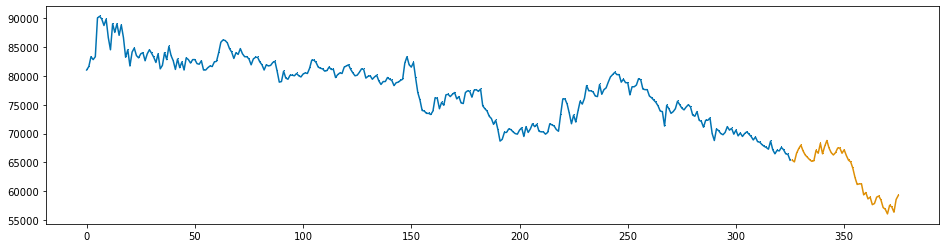

In [37]:
plot_series(y_train, y_valid, markers=[',', ','])

In [38]:
x_train

,High,Low,Close,Volume,Change
0,84400,80200,83000,38655276,0.024691
1,83900,81600,83900,35335669,0.010843
2,84500,82100,82200,42089013,-0.020262
3,84200,82700,82900,32644642,0.008516
4,90000,83000,88800,59013307,0.071170
...,...,...,...,...,...
321,68300,67500,67700,12847448,0.004451
322,67300,66700,67000,11791478,-0.010340
323,66700,66300,66300,11016474,-0.010448
324,66700,66100,66100,12946923,-0.003017


In [39]:
xgb_params = pd.read_csv('./hyperparameter_xgb_final.csv')

xgb_reg = XGBRegressor(n_estimators=10000, eta=xgb_params.iloc[47,1], min_child_weight=xgb_params.iloc[47,2],
                       max_depth=xgb_params.iloc[47,3], colsample_bytree=xgb_params.iloc[47,4],
                       subsample=xgb_params.iloc[47,5], seed=0)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
            early_stopping_rounds=300, verbose=False)

c:\Users\hoon9\anaconda3\envs\main\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

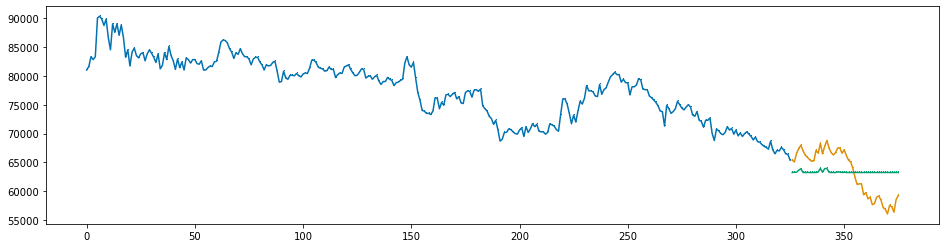

In [41]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',', ',', ','])